In [486]:
import soccerdata as sd
import pandas as pd
import sklearn as sk
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, deque # new
from sklearn.model_selection import GridSearchCV
 

from sklearn.feature_selection import SelectFromModel

In [487]:
# Create a scraper class instance for espn for the 2021/22 Premier League
espn = sd.MatchHistory(leagues=['GER-Bundesliga'], seasons=['2021-2022'])
# Get match data of each team
match_stats= espn.read_games()



[11/02/24 15:28:37] INFO     Saving cached data to /Users/kevinwildprett/soccerdata/data/MatchHistory ]8;id=435677;file:///Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/soccerdata/_common.py\_common.py]8;;\:]8;id=748855;file:///Users/kevinwildprett/Desktop/schule/miniconda3/envs/ml-course/lib/python3.8/site-packages/soccerdata/_common.py#89\89]8;;\

In [488]:
#match_stats.head()

In [489]:
# Convert MultiIndex into regular one
match_stats = match_stats.reset_index()
match_stats.reset_index(drop=True, inplace=True)
match_stats.head()


,league,season,game,date,home_team,away_team,FTHG,FTAG,FTR,HTHG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,GER-Bundesliga,2122,2021-08-13 M'gladbach-Bayern Munich,2021-08-13 19:30:00,M'gladbach,Bayern Munich,1,1,D,1,...,3.01,0.75,1.99,1.94,1.99,1.93,2.10,1.96,1.98,1.88
1,GER-Bundesliga,2122,2021-08-14 Augsburg-Hoffenheim,2021-08-14 14:30:00,Augsburg,Hoffenheim,0,4,A,0,...,2.30,0.25,1.97,1.96,1.98,1.94,2.02,1.99,1.96,1.91
2,GER-Bundesliga,2122,2021-08-14 Bielefeld-Freiburg,2021-08-14 14:30:00,Bielefeld,Freiburg,0,0,D,0,...,1.64,0.25,1.75,2.05,1.79,2.16,1.80,2.20,1.76,2.12
3,GER-Bundesliga,2122,2021-08-14 Dortmund-Ein Frankfurt,2021-08-14 17:30:00,Dortmund,Ein Frankfurt,5,2,H,3,...,3.09,-1.25,2.02,1.91,1.96,1.96,2.05,1.96,1.97,1.89
4,GER-Bundesliga,2122,2021-08-14 Stuttgart-Greuther Furth,2021-08-14 14:30:00,Stuttgart,Greuther Furth,5,1,H,2,...,2.16,-0.75,2.02,1.77,2.09,1.83,2.12,1.86,2.07,1.80


In [490]:
print(list(match_stats.columns.values))

['league', 'season', 'game', 'date', 'home_team', 'away_team', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA', 'MaxH', 'MaxD', 'MaxA', 'AvgH', 'AvgD', 'AvgA', 'B365>2.5', 'B365<2.5', 'P>2.5', 'P<2.5', 'Max>2.5', 'Max<2.5', 'Avg>2.5', 'Avg<2.5', 'AHh', 'B365AHH', 'B365AHA', 'PAHH', 'PAHA', 'MaxAHH', 'MaxAHA', 'AvgAHH', 'AvgAHA', 'B365CH', 'B365CD', 'B365CA', 'BWCH', 'BWCD', 'BWCA', 'IWCH', 'IWCD', 'IWCA', 'PSCH', 'PSCD', 'PSCA', 'WHCH', 'WHCD', 'WHCA', 'VCCH', 'VCCD', 'VCCA', 'MaxCH', 'MaxCD', 'MaxCA', 'AvgCH', 'AvgCD', 'AvgCA', 'B365C>2.5', 'B365C<2.5', 'PC>2.5', 'PC<2.5', 'MaxC>2.5', 'MaxC<2.5', 'AvgC>2.5', 'AvgC<2.5', 'AHCh', 'B365CAHH', 'B365CAHA', 'PCAHH', 'PCAHA', 'MaxCAHH', 'MaxCAHA', 'AvgCAHH', 'AvgCAHA']


In [491]:
# Extrahieren der Uhrzeit
time_column = match_stats['date'].dt.time

# Zusammenfügen des DataFrames mit der neuen Spalte, um Fragmentierung zu vermeiden
match_stats = pd.concat([match_stats, time_column.rename('time')], axis=1)

In [492]:

match_stats = match_stats.sort_values(by='date').reset_index(drop=True)

# Bulding new Features

In [493]:
# Dictionary to keep track of matchdays for each team
team_matchday_counts = defaultdict(int)

# Function to calculate matchdays for each team
def update_matchday(row):
    home_team = row['home_team']
    away_team = row['away_team']
    
    # Increment matchday count for home and away teams
    team_matchday_counts[home_team] += 1
    team_matchday_counts[away_team] += 1
    
    # Assign matchday counts to the row
    row['home_team_matchday'] = team_matchday_counts[home_team]
    row['away_team_matchday'] = team_matchday_counts[away_team]
    
    return row

In [494]:
# Apply the function to the DataFrame
match_stats = match_stats.apply(update_matchday, axis=1)

In [495]:
#match_stats.head()

In [496]:
# Dictionary to keep track of match history for each team
team_last_5_results = defaultdict(lambda: deque(maxlen=5))
team_last_performance_at_30 = defaultdict(int)  # Store performance at matchday 30

# Function to update the last 5 match history and count wins
def update_last_5_wins(row):
    home_team = row['home_team']
    away_team = row['away_team']
    home_matchday = row['home_team_matchday']
    away_matchday = row['away_team_matchday']
    
    # Initialize the last 5 wins for matchdays 1-5 to 0
    if home_matchday < 6:
        row['home_last_5_wins'] = 0
    else:
        # Calculate the number of wins in the last 5 matches for matchdays 6 and above
        row['home_last_5_wins'] = sum(team_last_5_results[home_team])
    
    if away_matchday < 6:
        row['away_last_5_wins'] = 0
    else:
        row['away_last_5_wins'] = sum(team_last_5_results[away_team])
    
    # Add current match result to history (after calculation)
    if row['FTR'] == 'H':  # Home team wins
        team_last_5_results[home_team].append(1)
        team_last_5_results[away_team].append(0)
    elif row['FTR'] == 'A':  # Away team wins
        team_last_5_results[home_team].append(0)
        team_last_5_results[away_team].append(1)
    else:  # Draw
        team_last_5_results[home_team].append(0)
        team_last_5_results[away_team].append(0)
    
    return row

# Apply the function to the DataFrame






In [497]:
match_stats = match_stats.apply(update_last_5_wins, axis=1)

In [499]:
# Dictionary to keep track of cumulative points for each team
team_points = defaultdict(int)

# Function to update cumulative points for each team
def update_cumulative_points(row):
    home_team = row['home_team']
    away_team = row['away_team']
    home_matchday = row['home_team_matchday']
    away_matchday = row['away_team_matchday']
    
    # Initialize cumulative points as 0 for the first matchday
    if home_matchday == 1:
        row['home_cumulative_points'] = 0
    else:
        row['home_cumulative_points'] = team_points[home_team]
    
    if away_matchday == 1:
        row['away_cumulative_points'] = 0
    else:
        row['away_cumulative_points'] = team_points[away_team]
    
    # Update points based on match result (add to history after setting current cumulative points)
    if row['FTR'] == 'H':  # Home team wins
        team_points[home_team] += 3  # 3 points for home team
        team_points[away_team] += 0  # 0 points for away team
    elif row['FTR'] == 'A':  # Away team wins
        team_points[home_team] += 0  # 0 points for home team
        team_points[away_team] += 3  # 3 points for away team
    else:  # Draw
        team_points[home_team] += 1  # 1 point for home team
        team_points[away_team] += 1  # 1 point for away team
    
    return row


In [500]:
match_stats = match_stats.apply(update_cumulative_points, axis=1)

In [501]:
# Dictionary to store the results of the first-leg matches (matchdays 1 to 17)
first_leg_results = defaultdict(dict)

def calculate_first_leg_performance(row):
    home_team = row['home_team']
    away_team = row['away_team']
    matchday = row['home_team_matchday']
    result = row['FTR']
    
    # Store results only for matchdays 1 to 17 (first leg)
    if matchday <= 17:
        if result == 'H':  # Home team wins
            first_leg_results[home_team][away_team] = 'W'  # Win for home team
            first_leg_results[away_team][home_team] = 'L'  # Loss for away team
        elif result == 'A':  # Away team wins
            first_leg_results[home_team][away_team] = 'L'  # Loss for home team
            first_leg_results[away_team][home_team] = 'W'  # Win for away team
        elif result == 'D':  # Draw
            first_leg_results[home_team][away_team] = 'D'  # Draw for both teams
            first_leg_results[away_team][home_team] = 'D'  # Draw for both teams
    
    # Assign the performance for matchdays of second leg
    if matchday < 17:
        row['home_first_leg_performance'] = 0
        row['away_first_leg_performance'] = 0
    else:
        row['home_first_leg_performance'] = first_leg_results.get(home_team, {}).get(away_team, 'N/A')
        row['away_first_leg_performance'] = first_leg_results.get(away_team, {}).get(home_team, 'N/A')
    
       
    
    return row


In [502]:
match_stats = match_stats.apply(calculate_first_leg_performance, axis=1)

In [503]:
# Dictionary to keep track of the number of shots on target for each team in the last 5 matches
team_last_5_shots = defaultdict(lambda: deque(maxlen=5))

# Function to update the number of shots on target for each team in the last 5 matches
def update_last_5_shots(row):
    home_team = row['home_team']
    away_team = row['away_team']
    home_matchday = row['home_team_matchday']
    away_matchday = row['away_team_matchday']
    
    # Initialize the number of shots for matchdays 1-5 to 0
    if home_matchday < 6:
        row['home_last_5_shots'] = 0
    else:
        # Calculate the total shots on target in the last 5 matches for matchdays 6 and above
        row['home_last_5_shots'] = sum(team_last_5_shots[home_team])
    
    if away_matchday < 6:
        row['away_last_5_shots'] = 0
    else:
        row['away_last_5_shots'] = sum(team_last_5_shots[away_team])
    
    # Add current match shots on target to history
    team_last_5_shots[home_team].append(row['HST'])  # Home shots on target
    team_last_5_shots[away_team].append(row['AST'])  # Away shots on target
    
    return row
# Apply the function to the DataFrame
match_stats = match_stats.apply(update_last_5_shots, axis=1)

In [504]:
# Dictionary to keep track of the goal differences for each team in the last 5 matches
team_last_5_goal_diff = defaultdict(lambda: deque(maxlen=5))

# Function to update the goal difference for each team in the last 5 matches
def update_last_5_goal_diff(row):
    home_team = row['home_team']
    away_team = row['away_team']
    home_matchday = row['home_team_matchday']
    away_matchday = row['away_team_matchday']
    
    # Calculate the current match goal difference
    home_goal_diff = row['FTHG'] - row['FTAG']
    away_goal_diff = -home_goal_diff  # Invert for the away team

    # Add current match goal difference to history
    team_last_5_goal_diff[home_team].append(home_goal_diff)
    team_last_5_goal_diff[away_team].append(away_goal_diff)
    
    # Initialize the goal difference for matchdays 1-5 to 0
    if home_matchday < 6:
        row['home_last_5_goal_diff'] = 0
    else:
        # Calculate the total goal difference in the last 5 matches for matchdays 6 and above
        row['home_last_5_goal_diff'] = sum(team_last_5_goal_diff[home_team])
    
    if away_matchday < 6:
        row['away_last_5_goal_diff'] = 0
    else:
        row['away_last_5_goal_diff'] = sum(team_last_5_goal_diff[away_team])
    
    return row

# Apply the function to the DataFrame
match_stats = match_stats.apply(update_last_5_goal_diff, axis=1)

In [505]:
#Verschlechtert, die Genauigkeit( gerade nicht verwendet)

# Dictionary to keep track of half-time goals for each team in the last 5 matches
team_last_5_half_time_goals = defaultdict(lambda: deque(maxlen=5))

# Function to calculate and update the sum of half-time goals for the last 5 matches for each team
def calculate_last_5_half_time_goals(row):
    home_team = row['home_team']
    away_team = row['away_team']
    home_matchday = row['home_team_matchday']
    away_matchday = row['away_team_matchday']
    
    # Calculate the sum for matchdays 6 and above; initialize with 0 for matchdays 1-5
    
    if home_matchday < 6:
        row['home_last_5_half_time_goals'] = 0 
    else:
        row['home_last_5_half_time_goals']= sum(team_last_5_half_time_goals[home_team])
    
    if away_matchday < 6:
        row['away_last_5_half_time_goals'] = 0 
    else:
        row['away_last_5_half_time_goals']= sum(team_last_5_half_time_goals[away_team])
    
    # Add the current match half-time goals to history
    team_last_5_half_time_goals[home_team].append(row['HTHG'])
    team_last_5_half_time_goals[away_team].append(row['HTAG'])
    
    
    
    
    return row

# Apply the function to the DataFrame
match_stats = match_stats.apply(calculate_last_5_half_time_goals, axis=1)



In [506]:
# Creats a Excel Sheet as a output
#new= match_stats[['home_team','away_team','FTHG','FTAG','HTHG','HTAG','HST' ,'AST','home_team_matchday', 'away_team_matchday','home_last_5_wins', 'away_last_5_wins','home_cumulative_points','away_cumulative_points', 'home_first_leg_performance','away_first_leg_performance', 'home_last_5_shots', 'away_last_5_shots', 'home_last_5_goal_diff','away_last_5_goal_diff',]]
#new.to_excel('stats_mit_Features.xlsx', index=False)

 # Feature Engineering

In [507]:
prediction_df = match_stats[['home_team',  'away_team', 'home_team_matchday', 'away_team_matchday','home_last_5_wins', 'away_last_5_wins','home_cumulative_points','away_cumulative_points', 'home_first_leg_performance','away_first_leg_performance','FTR', 'home_last_5_shots', 'away_last_5_shots','home_last_5_goal_diff','away_last_5_goal_diff'  ]]

In [508]:
# Hyperparameter finden
# One-Hot-Encoding für kategoriale Spalten
#categorical_features = pd.get_dummies(prediction_df[['home_team', 'away_team', 'home_first_leg_performance', 'away_first_leg_performance','time']])

# Numerische Spalten
#numerical_features = prediction_df[['home_team_matchday', 'away_team_matchday', 'home_last_5_wins', 'away_last_5_wins', 'away_cumulative_points', 'home_cumulative_points', 'home_last_5_shots', 'away_last_5_shots', 'home_last_5_goal_diff', 'away_last_5_goal_diff','home_last_5_half_time_goals', 'away_last_5_half_time_goals']]

# Features und Label
#X = pd.concat([categorical_features, numerical_features], axis=1)
#le = LabelEncoder()
#y = le.fit_transform(prediction_df['FTR'])

# Test-/Train-Masken
#train_mask = (prediction_df['home_team_matchday'] >= 18) & (prediction_df['home_team_matchday'] <= 30)
#test_mask = (prediction_df['home_team_matchday'] >= 31) & (prediction_df['home_team_matchday'] <= 34)

# Train/Test-Split
#X_train, X_test = X[train_mask], X[test_mask]
#y_train, y_test = y[train_mask], y[test_mask]

# GridSearchCV-Parameter
#param_grid = {
 #   'n_estimators': [100, 200, 300],
  #  'max_depth': [10, 20, 30, None],
   # 'min_samples_split': [2, 5, 10],
    #'min_samples_leaf': [1, 2, 4],
    #'class_weight': ['balanced', 'balanced_subsample']
#}

# RandomForestClassifier und GridSearchCV
#rf_model = RandomForestClassifier(random_state=42)
#grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Fit auf die Trainingsdaten
#grid_search.fit(X_train, y_train)

# Beste Parameter und Modell anzeigen
#print("Beste Hyperparameter:", grid_search.best_params_)
#best_rf_model = grid_search.best_estimator_

# Vorhersage
#y_pred = best_rf_model.predict(X_test)

# Anzeige der Vorhersagen und der Testdaten-Accuracy

#print("Testdaten-Accuracy:", accuracy_score(y_test, y_pred))

In [509]:
le = LabelEncoder()

# One-Hot-Encoding only for the categorical columns 
categorical_features = pd.get_dummies(prediction_df[['home_team','away_team', 'home_first_leg_performance','away_first_leg_performance' ]])

numerical_features = prediction_df[[ 'home_team_matchday', 'away_team_matchday','home_last_5_wins', 'away_last_5_wins' ,'away_cumulative_points','home_cumulative_points', 'home_last_5_shots', 'away_last_5_shots','home_last_5_goal_diff','away_last_5_goal_diff' ]] 

X = pd.concat([categorical_features, numerical_features], axis=1)
y = le.fit_transform(prediction_df['FTR'])

# Test / Train Mask
train_mask = (prediction_df['home_team_matchday'] >= 18) & (prediction_df['home_team_matchday'] <= 30)
test_mask = (prediction_df['home_team_matchday'] >= 31) & (prediction_df['home_team_matchday'] <= 34)


X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]


## Implementing Random Forest + Training

In [510]:
rf_model = RandomForestClassifier(n_estimators=100,random_state=42,max_depth=10, class_weight='balanced' )
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)


## Evaluation ##

In [511]:
print("Accuracy:", accuracy_score(y_test, y_pred))

# alternative evaluation with  cross validation
cross_val_scores = cross_val_score(rf_model, X_train, y_train, cv=5)

print("Cross-Validation Scores:", cross_val_scores)
print("Average Cross-Validation:", cross_val_scores.mean())

Accuracy: 0.5277777777777778
Cross-Validation Scores: [0.66666667 0.5        0.65217391 0.60869565 0.60869565]
Average Cross-Validation: 0.6072463768115941


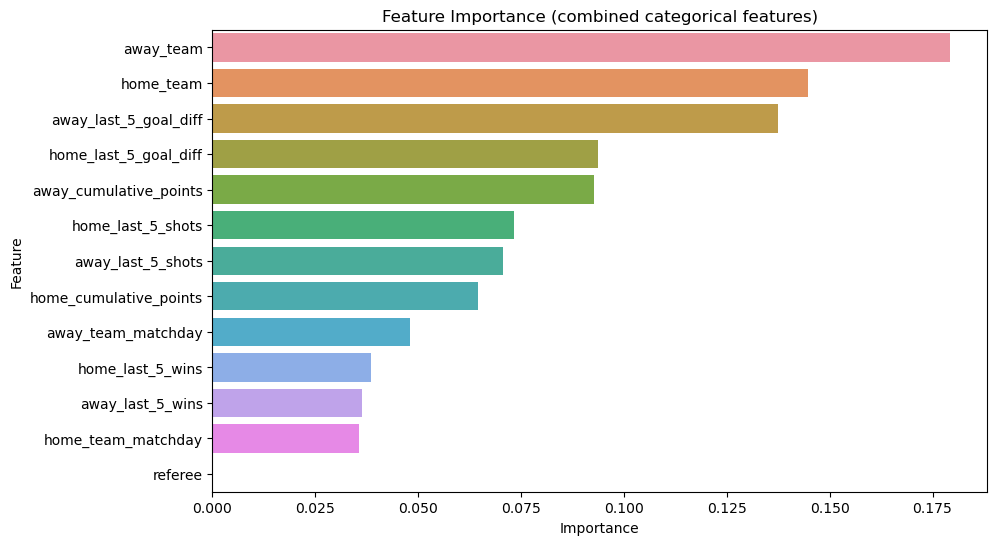

In [512]:
# calculate Feature Importance 
importances = rf_model.feature_importances_
feature_names = X_train.columns

# store it in Dataframe
feature_importances_df = pd.DataFrame({'Feature': feature_names,'Importance': importances})

# Group one-hot encoded features based on prefixes
grouped_importances = {
    'home_team': feature_importances_df[feature_importances_df['Feature'].str.startswith('home_team')]['Importance'].sum(),
    'away_team': feature_importances_df[feature_importances_df['Feature'].str.startswith('away_team')]['Importance'].sum(),
    'referee': feature_importances_df[feature_importances_df['Feature'].str.startswith('referee')]['Importance'].sum()
}

# add numeric features

for feature in numerical_features:
    if feature in feature_importances_df['Feature'].values:
        grouped_importances[feature] = feature_importances_df.loc[feature_importances_df['Feature'] == feature, 'Importance'].values[0]
    else:
        print(f"Feature {feature} not Found")

# Convert grouped importances in one dataframe
grouped_importances_df = pd.DataFrame(list(grouped_importances.items()), columns=['Feature', 'Importance'])

# sort based on importance
grouped_importances_df = grouped_importances_df.sort_values(by='Importance', ascending=False)

# create and plot the diagram
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=grouped_importances_df)
plt.title('Feature Importance (combined categorical features)')
plt.show()